# PLAYING WITH THE TENSORFLOW API

***

***

# Packages

In [1]:
# Essential libraries.
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

# Modules.
import tensorflow.keras.layers as tfl
from tensorflow.keras.utils import image_dataset_from_directory

# Information.
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.9.1
Num GPUs Available:  1


2022-08-29 13:30:48.446158: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-29 13:30:48.452310: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-29 13:30:48.452507: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


***

***

# Dataset

## Split into training and validation sets

When training and evaluating deep learning models in Keras, generating a dataset from image files stored on disk is simple and fast. Call `image_data_set_from_directory()` to read from the directory and create both training and validation datasets. 

If you're specifying a validation split, you'll also need to specify the subset for each portion. Just set the training set to `subset='training'` and the validation set to `subset='validation'`.

You'll also set your seeds to match each other, so your training and validation sets don't overlap.

In [2]:
batch_size = 32
img_size = (224, 224)
directory = "Sentinel2GlobalLULC/Sentinel2LULC_JPEG/"

train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=batch_size,
                                             image_size=img_size,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)

validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=batch_size,
                                             image_size=img_size,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 194877 files belonging to 29 classes.
Using 155902 files for training.


2022-08-29 13:30:54.613673: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-29 13:30:54.614384: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-29 13:30:54.614559: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-29 13:30:54.614652: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Found 194877 files belonging to 29 classes.
Using 38975 files for validation.


## Show some examples from the training set

29


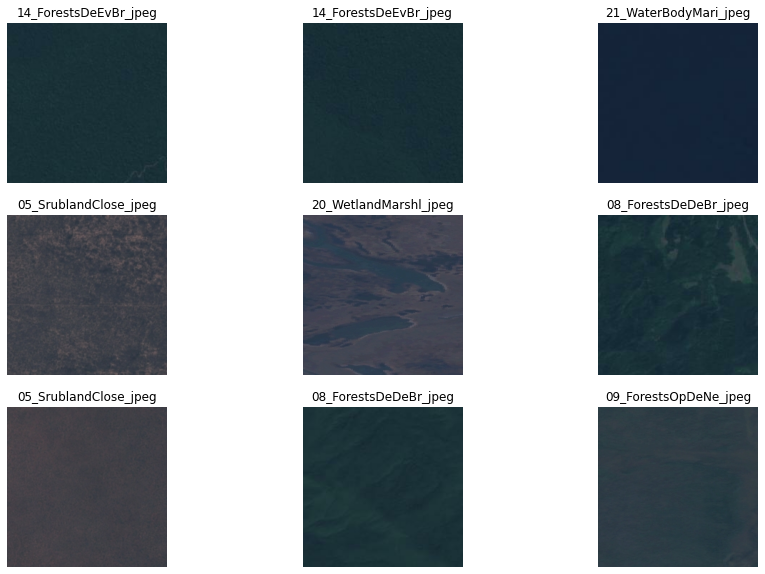

In [3]:
class_names = train_dataset.class_names
print(len(class_names))

plt.figure(figsize=(15, 10))

for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

***

***

# Preprocesses

## Prefetch()

You may have encountered `dataset.prefetch` in a previous TensorFlow assignment, as an important extra step in data preprocessing. 

Using `prefetch()` prevents a memory bottleneck that can occur when reading from disk. It sets aside some data and keeps it ready for when it's needed, by creating a source dataset from your input data, applying a transformation to preprocess it, then iterating over the dataset one element at a time. Because the iteration is streaming, the data doesn't need to fit into memory.

You can set the number of elements to prefetch manually, or you can use `tf.data.experimental.AUTOTUNE` to choose the parameters automatically. Autotune prompts `tf.data` to tune that value dynamically at runtime, by tracking the time spent in each operation and feeding those times into an optimization algorithm. The optimization algorithm tries to find the best allocation of its CPU budget across all tunable operations. 

In [4]:
autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=autotune)

## Augmenting training data

To increase diversity in the training set and help your model learn the data better, it's standard practice to augment the images by transforming them, i.e., randomly flipping and rotating them. Keras' Sequential API offers a straightforward method for these kinds of data augmentations, with built-in, customizable preprocessing layers. These layers are saved with the rest of your model and can be re-used later.  Ahh, so convenient! 

As always, you're invited to read the official docs, which you can find for data augmentation [here](https://www.tensorflow.org/tutorials/images/data_augmentation).

***

***

# Model